In [2]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as ps
import matplotlib.pyplot as plt
from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.Waveform import Waveform
import numpy as np
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet

ModuleNotFoundError: No module named 'waffles'

In [1]:
runresponse=25171
runtemplate=0
ch = 11225
fileresponse = f'/eos/home-h/hvieirad/waffles/analysis/responses/response_run0{runresponse}_ch{ch}.pkl'
filetemplate = f'/eos/home-h/hvieirad/waffles/analysis/templates/template_run0{runtemplate}_ch{ch}.pkl'

wfsetresponse = pickle_file_to_WaveformSet(fileresponse)
wfsettemplate = pickle_file_to_WaveformSet(filetemplate)

NameError: name 'pickle_file_to_WaveformSet' is not defined

In [82]:
import numpy as np
from scipy import interpolate

def shift_waveform_continuous_fowards(waveform, shift_amount):
    
    shift_round = round(shift_amount - shift_amount%1)
    shift_fraction = shift_amount % 1
    # Create an array of indices corresponding to the original waveform
    original_indices = np.arange(len(waveform))

    shifted_waveform = np.roll(waveform, shift_round, axis=0)

    # The new indices we want to interpolate at, shifted by the shift_amount
    new_indices = original_indices - shift_fraction

    # Use scipy's interp1d to create a linear interpolator
    interpolator = interpolate.interp1d(original_indices, shifted_waveform, kind='linear', fill_value="extrapolate")

    # Interpolate the waveform at the new shifted indices
    shifted_waveform = interpolator(new_indices)

    return shifted_waveform

# plt.plot(wfsetresponse.avgwvf)
# plt.plot(10*wfsettemplate.avgwvf)
# wvfshift = np.roll(wfsetresponse.avgwvf, 69, axis=0)
# wvfshift = shift_waveform_continuous_fowards(wvfshift,0.8)
# plt.plot(wvfshift)
# plt.xlim(50,200)


In [83]:
import math
def find_threshold_crossing(waveform, threshold_per_cent:float):
    threshold = threshold_per_cent*np.max(waveform)
    # Find indices where the waveform crosses the threshold (positive slope)
    crossings = np.where(np.diff(np.sign(waveform - threshold)) > 0)[0]
    
    if len(crossings) == 0:
        raise ValueError("No threshold crossing found in the waveform.")
    
    # For simplicity, let's take the first crossing point
    # Interpolate between the two points that straddle the threshold crossing
    idx_before = crossings[0]
    y1, y2 = waveform[idx_before], waveform[idx_before + 1]
    x1, x2 = idx_before, idx_before + 1
    
    # Linear interpolation to find the exact fractional index of crossing
    fractional_crossing = x1 + (threshold - y1) / (y2 - y1)
    
    return fractional_crossing

def get_new_avg(wvfs: WaveformSet, threshold:float = 0.1, target=125):
    for __wvf in wvfs.waveforms:
        wvf = (__wvf.adcs.astype(np.float32) - __wvf.baseline)*-1
        __wvf.shiftedwvf, shift = shift_waveform_to_align_threshold(wvf, threshold, target)

def shift_waveform_to_align_threshold(waveform, threshold, target_index=135):
    # Find the crossing point (fractional index)
    crossing_point = find_threshold_crossing(waveform, threshold)
    
    # Compute how much we need to shift the waveform to align the crossing point to `target_index`
    if (target_index == -1):
        shift_amount = crossing_point % 1
    shift_amount = target_index - crossing_point
    
    # Shift the waveform by this amount using linear interpolation
    return shift_waveform_continuous_fowards(waveform, shift_amount), round(shift_amount)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.131e+04 (χ²/ndof = 2.8)  │              Nfcn = 595              │
│ EDM = 1.08e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

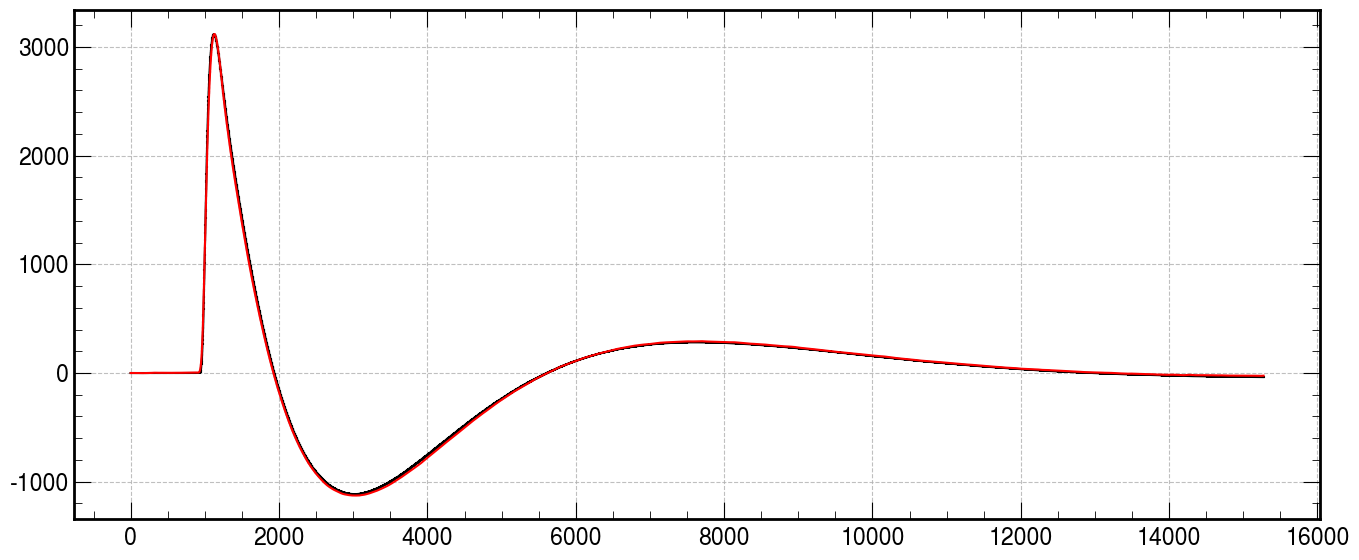

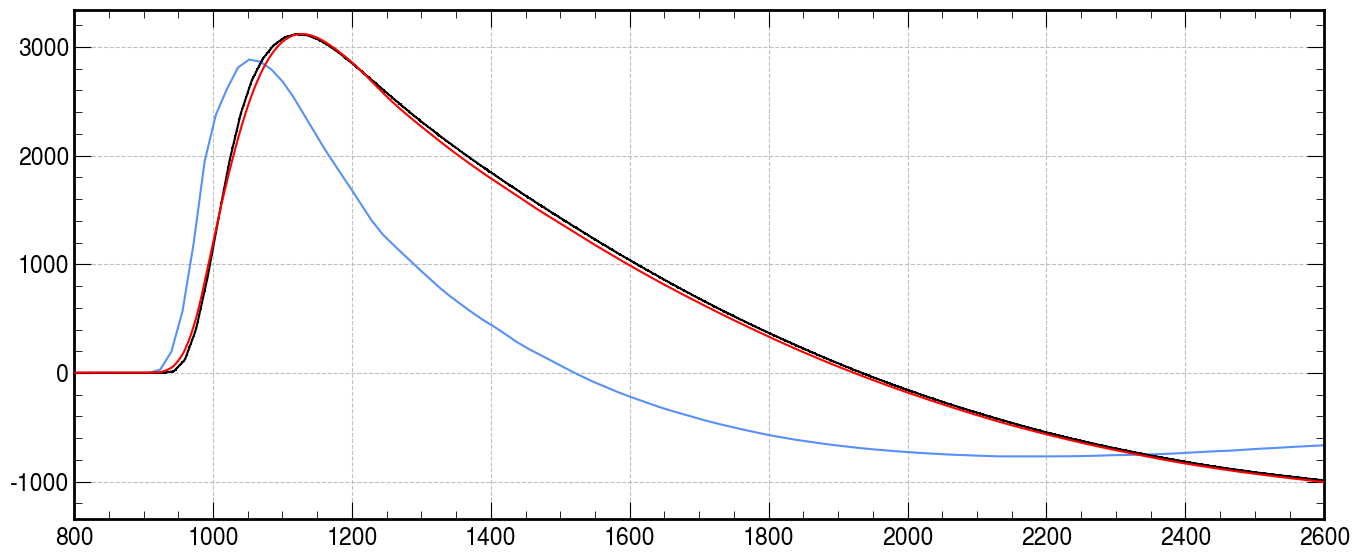

In [84]:
from iminuit import Minuit, cost
from iminuit.util import describe

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 20,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })




template = wfsettemplate.avgwvf.copy()
data = wfsetresponse.avgwvf.copy()
times = np.linspace(0,len(data)*16,len(data),endpoint=False)
newtimes = np.linspace(0,len(data)*16,8*len(data),endpoint=False)
interpolator = interpolate.interp1d(times, data, kind='linear', fill_value="extrapolate")
data = interpolator(newtimes)
interpolator = interpolate.interp1d(times, template, kind='linear', fill_value="extrapolate")
template = interpolator(newtimes)
# data = avgwvf
# offset_initial = 0
# data = data[offset_initial:]
# template = template[offset_initial:]

offsettemplate = find_threshold_crossing(template, 0.27)
# # data = np.roll(data, offset, axis=0)
#apply extraoffset
data, offset = shift_waveform_to_align_threshold(data, threshold=0.05, target_index=offsettemplate)
# data = shift_waveform_continuous_fowards(data, offsettemplate)
data = data[offset:]
template = template[offset:]



times = np.linspace(0,len(data)*2,len(data),endpoint=False)
errors = np.ones(len(data))*10




def model(t, A, fp, t1, t3):
    offset = 0
    # y = np.zeros(len(t),dtype=float)
    y = A*(fp*np.exp(-t/t1)/t1 + (1-fp)*np.exp(-t/t3)/t3)
    return np.convolve(y,template,mode='full')[:len(y)]

mycost = cost.LeastSquares(times, data, errors, model)
# def mycost(A, fp, t1, t3):
#     expected_response = model(times, A, fp, t1, t3)
#     norm_for_error = (np.abs(expected_response.copy()/np.max(expected_response)))
#     diff = (expected_response - data)**2/errors**2
#     diff = diff[1000//16:]
#     return np.sum(diff)
    

A = 10e3
fp = 0.28
t1 = 35
t3 = 1600

m = Minuit(mycost, A=A,fp=fp,t1=t1,t3=t3)

m.limits['A'] = (0,None)
m.limits['fp'] = (0,1)
m.limits['t1'] = (2,50)
m.limits['t3'] = (500,2000)


# m.fixed['t1'] = True
m.fixed['fp'] = True
m.migrad()
m.migrad()
m.migrad()
m.fixed['fp'] = False
m.migrad()
m.migrad()
m.migrad()
print(m)

pars = describe(model)[1:]
vals = [m.values[p] for p in pars]
print(m.fmin.fval/(len(model(times, *vals)[70:])-2), m.fmin.reduced_chi2)

plt.figure()
plt.errorbar(times,data,errors,fmt='-k')
plt.plot(times,model(times,*vals),color='r',zorder=100)
plt.figure()
plt.errorbar(times,data,errors,fmt='-k')
plt.plot(times,model(times,*vals),color='r',zorder=100)
plt.plot(times, template*20)
plt.xlim(800,2600)
plt.show()


<Figure size 1400x600 with 0 Axes>

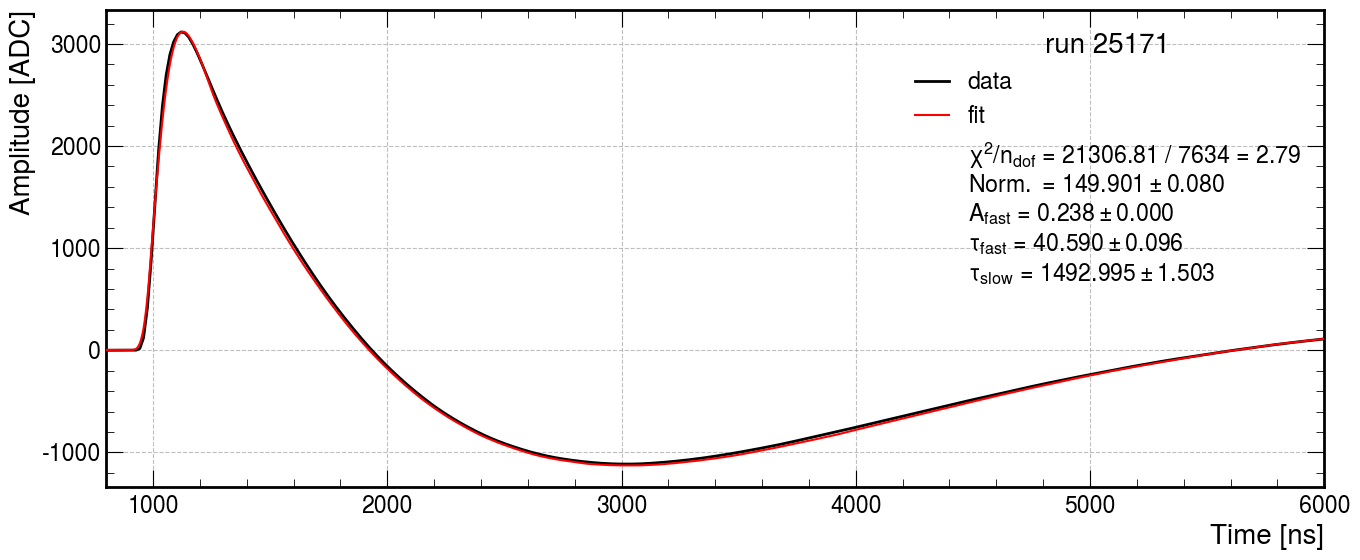

<Figure size 1400x600 with 0 Axes>

In [85]:
import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 20,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })
pars = describe(model)[1:]
vals = [m.values[p] for p in pars]

plt.plot(times,data,'-', lw=2 ,color='k', label='data')
plt.plot(times,model(times,*vals),color='r',zorder=100,label='fit')
plt.xlim(times[0],times[-1])
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.2f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]

mapnames = {
'A': 'Norm.',
'fp': 'A_\\text{fast}',
't1': '\\tau_\\text{fast}',
't3': '\\tau_\\text{slow}',
}
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"${mapnames[p]}$ = ${v:.3f} \\pm {e:.3f}$")
plt.plot([],[], ' ', label='\n'.join(fit_info))
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude [ADC]')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
# order = [3,0,1,2]

#add legend to plot
plt.legend(title=f'run {runresponse}')
plt.xlim(800,6000)
plt.figure()


In [392]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=wfsettemplate.avgwvf, mode='lines', name='data'))
# fig.add_trace(go.Scatter(x=times, y=data, mode='lines', name='data'))
# for v in range(1000,1400,50):
#     vals[3] = v
#     fig.add_trace(go.Scatter(x=times, y=(model(times,*vals))/np.max(model(times,*vals)), mode='lines', name=f"{vals[3]:.1f}"))
fig.update_layout(
    width=1320,
    height=880)
fig.show()
# plt.plot(times,data,'-', lw=2 ,color='k', label='data')
# plt.plot(times,model(times,*vals),color='r',zorder=100,label='fit')

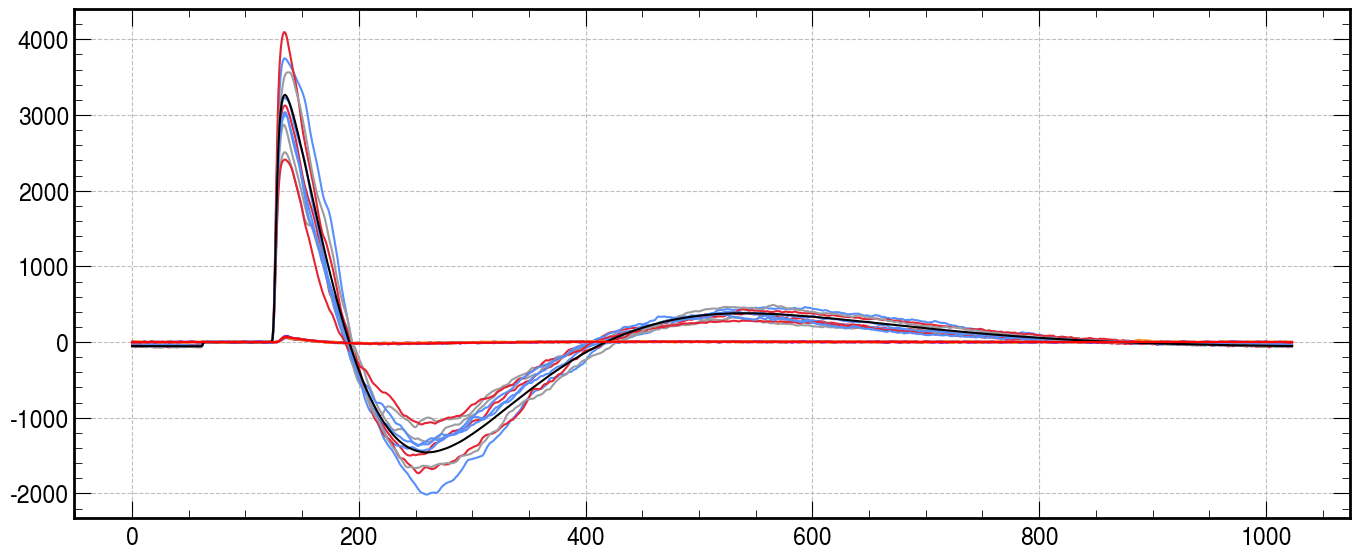

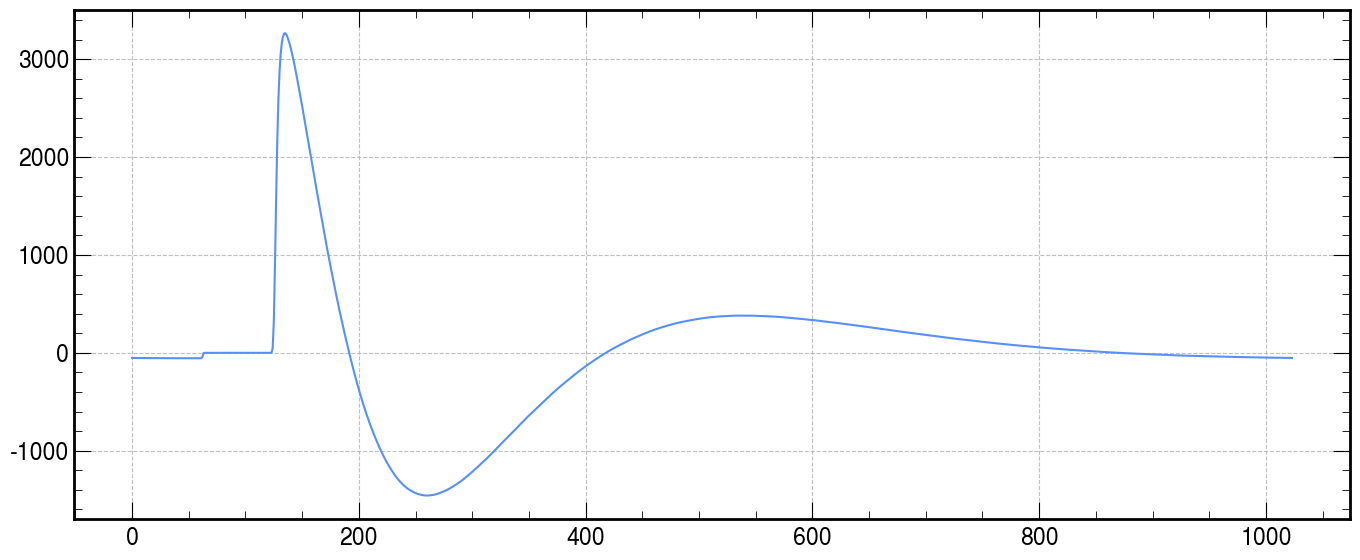

In [393]:
get_new_avg(wfsetresponse, target=125)
get_new_avg(wfsettemplate, threshold=0.25, target=130)
for wvfs, wvfstemp in zip(wfsetresponse.waveforms[:10], wfsettemplate.waveforms):
    plt.plot(wvfs.shiftedwvf)
    plt.plot(wvfstemp.shiftedwvf)
    
wvf_arrays = np.array([waveform.shiftedwvf for waveform in wfsetresponse.waveforms])
avgwvf = np.mean(wvf_arrays, axis=0)
plt.plot(avgwvf, '-k')

wvf_arrays = np.array([waveform.shiftedwvf for waveform in wfsettemplate.waveforms])
avgwvf_template = np.mean(wvf_arrays, axis=0)
plt.plot(avgwvf_template, '-r')
plt.figure()
plt.plot(avgwvf)